## Loading data and Necessary libraries

**References:**
* Splitting into Train and Test https://towardsdatascience.com/if-you-cant-measure-it-you-can-t-improve-it-5c059014faad
* Official documentation http://surpriselib.com/
* Basic tutorial https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
* Predicting on Test https://surprise.readthedocs.io/en/stable/FAQ.html#raw-inner-note
* Top N recommendations for each user https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-save-some-data-for-unbiased-accuracy-estimation

In [111]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Surprise Package
import surprise

In [4]:
# Read data
train_df = pd.read_pickle("../../../train_df.pkl")
test_df = pd.read_pickle("../../../test_df.pkl")

In [8]:
# Explore set shapes
print(train_df.shape)
print(test_df.shape)

(206085, 20)
(84554, 20)


In [6]:
# Explore train set
train_df.head()

,reviewID,overall,verified,reviewTime,reviewerID,productID,reviewText,summary,vote,style,category,title,brand,rank,main_cat,description,also_buy,also_view,feature,numberOfReviews
473590,473590,5,False,2016-07-16,A2KJVIU82ZUSBA,B0186D1UQ0,Fantastic,Best Remake I've Ever Played,0,{'Format:': ' Video Game'},"['Video Games', 'PlayStation 4', 'Games', '']",Odin Sphere Leifthrasir - PlayStation 4 Standa...,by Atlus,">#4,665 in Video Games (See Top 100 in Video G...",Video Games,"[""ATLUS x Vanillaware, the team behind the hit...","['B077Y7313L', 'B0794Y8FLW', 'B01HQGWBZ2', 'B0...","['B077Y7313L', 'B0794Y8FLW', 'B017GY06UQ', 'B0...","['HD Art Upgrade: Known for its beautiful, 2D ...",26
128446,128446,5,True,2014-07-18,A3GENOZU8QJZAZ,B000R39GPA,Great game,PS3,0,"{'Edition:': ' Standard', 'Platform:': ' PlayS...","['Video Games', 'PlayStation 3', 'Games', '']",Star Wars: The Force Unleashed,by LucasArts,">#9,056 in Video Games (See Top 100 in Video G...",Video Games,['The Star Wars saga will continue in Star War...,"['B0030F1DOO', 'B003FMUMBM', 'B00EY3F8LU', 'B0...","['B01BCMBP44', 'B0030F1DOO', 'B00EY3F8LU', 'B0...",['Confront and associate with familiar faces f...,140
356264,356264,3,True,2015-07-03,ADE6VBLJEOKFC,B00DHF39HQ,Its a game with stuff thats really boring to s...,Buy a car.,2,{'Format:': ' Video Game'},"['Video Games', 'PlayStation 4', 'Games', '']",Elder Scrolls Online: Tamriel Unlimited - Play...,by Bethesda,">#5,896 in Video Games (See Top 100 in Video G...",Video Games,"[""The award winning Elder Scrolls saga goes on...","['B01MSDDCUI', 'B07BJ66LRB', 'B01I41HEGY', 'B0...","['B07BJ66LRB', 'B01I41HEGY', 'B01MSDDCUI', 'B0...","['Unlimited Adventures, No Subscription Requir...",135
396581,396581,5,True,2014-12-25,AGS25M1ED8EGZ,B00K848IH0,love it,great,0,"{'Edition:': ' Alpha Sapphire', 'Platform:': '...","['Video Games', 'Kids & Family', 'Nintendo 3DS...",Pokemon Alpha Sapphire - Nintendo 3DS,by Nintendo,>#837 in Video Games (See Top 100 in Video Gam...,Video Games,"[""Soar high above the Hoenn region on an unfor...","['B0053B66KE', 'B0053B5RGI', 'B071WNTGFY', 'B0...","['B0053B5RGI', 'B00R11EPAC', 'B071JQQ9PK', 'B0...",['Games in 2D. Some areas also playable in 3D....,267
244246,244246,4,True,2011-07-15,A1CZT2GDDO4GC1,B003O6G1L4,The main people who are really DOWNING this ga...,"It's not that bad of a game, but does lack a l...",5,"{'Edition:': ' Standard', 'Platform:': ' PlayS...","['Video Games', 'PlayStation 3', 'Games', '']",Dungeon Siege III - Playstation 3,by Square Enix,">#19,535 in Video Games (See Top 100 in Video ...",Video Games,"[""Torn asunder, the delicate balance of power ...","['B00IQCRO3K', 'B001BTPRKC', 'B000HCJD68', 'B0...","['B00IQCRO3K', 'B007V9QKH0', 'B00B59MXGY', 'B0...","['For the first time, play DUNGEON SIEGE on hi...",43


In [34]:
# Possible values for ratings
pd.concat([train_df, test_df])["overall"].value_counts()

5    170016
4     57442
3     31130
1     17244
2     14807
Name: overall, dtype: int64

In [38]:
ratings_summary = pd.DataFrame(pd.concat([train_df, test_df]).groupby(["overall"]).count()["productID"]).reset_index()
ratings_summary.columns = ["Rating", "Count"]
ratings_summary

,Rating,Count
0,1,17244
1,2,14807
2,3,31130
3,4,57442
4,5,170016


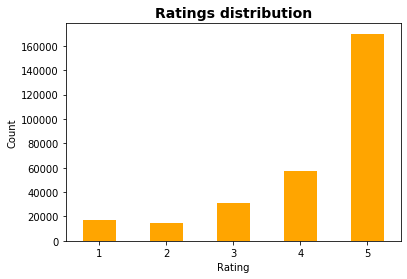

In [83]:
ax = ratings_summary.plot(x = "Rating", y = "Count", kind = "bar", color = "orange", legend = False, figsize = (6, 4))
plt.xticks(rotation=0)
plt.ylabel("Count")
#ax.set_ylabel(ylabel = "Count", position=(0,1), fontsize = 12)
plt.title("Ratings distribution", fontweight = "bold", fontsize = 14)
plt.show()

# With Surprise Package

## Loading data into Surprise

In [85]:
# Instantiate reader object, to parse ratings
reader = surprise.Reader(rating_scale=(1, 5))

In [86]:
# Load Train data into Surprise, from train_df and using reader instantiated above
surprise_data_train = surprise.Dataset.load_from_df(train_df[['reviewerID', 'productID', 'overall']], reader)

## Training the model

In [87]:
# Define parameter grid
param_grid = {"n_factors": [10, 20, 30, 40, 50],
              "n_epochs": [25, 50, 75]}

In [110]:
# Instantiate grid search CV
grid_search = surprise.model_selection.GridSearchCV(algo_class = surprise.NMF, 
                                                    param_grid = param_grid, 
                                                    measures=['rmse'], 
                                                    cv = 5, 
                                                    n_jobs = 7)

In [91]:
# Look for best parameters on train data
grid_search.fit(surprise_data_train)

In [92]:
# Best RMSE score (prediction of what Test RMSE will be)
print(grid_search.best_score['rmse'])

1.1566126294866532


In [93]:
# Combination of parameters that gave the best RMSE score
print(grid_search.best_params['rmse'])

{'n_factors': 40, 'n_epochs': 50}


In [97]:
# Get model with best performance
best_NMF = grid_search.best_estimator['rmse']

## Predicting on Train Set

In [98]:
# Fit best NMF on Train
best_NMF.fit(surprise_data_train.build_full_trainset())

In [107]:
predictions_train = best_NMF.test(surprise_data_train.build_full_trainset().build_testset())
surprise.accuracy.rmse(predictions_train)

RMSE: 0.3779


0.37791368279108

## Predicting on Test Set

In [103]:
test_list = []

In [104]:
for _, row in test_df.iterrows():
    t = (row["reviewerID"], row["productID"], row["overall"])
    test_list.append(t)

In [105]:
# Predict using best model found
test_predictions = best_NMF.test(test_list)

In [106]:
# Compute Test RMSE
surprise.accuracy.rmse(test_predictions)

RMSE: 1.1335


1.1335048210152516